<a href="https://colab.research.google.com/github/Artenida/computer-vision-exercises/blob/main/Exercise4_M3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Generate synthetic image with random blobs**

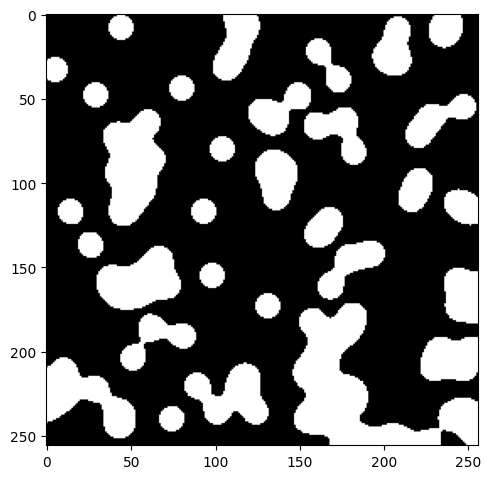

In [4]:
from skimage import data, measure
import skimage as sk
import matplotlib.pyplot as plt

IG = data.binary_blobs(length=256, blob_size_fraction=0.1, volume_fraction=0.3)

fig = plt.figure(figsize=(5,5))
plt.imshow(IG, cmap='gray')
plt.tight_layout()
plt.show()

**2. Object segmentation and labeling**

/usr/local/lib/python3.11/dist-packages/skimage/exposure/exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


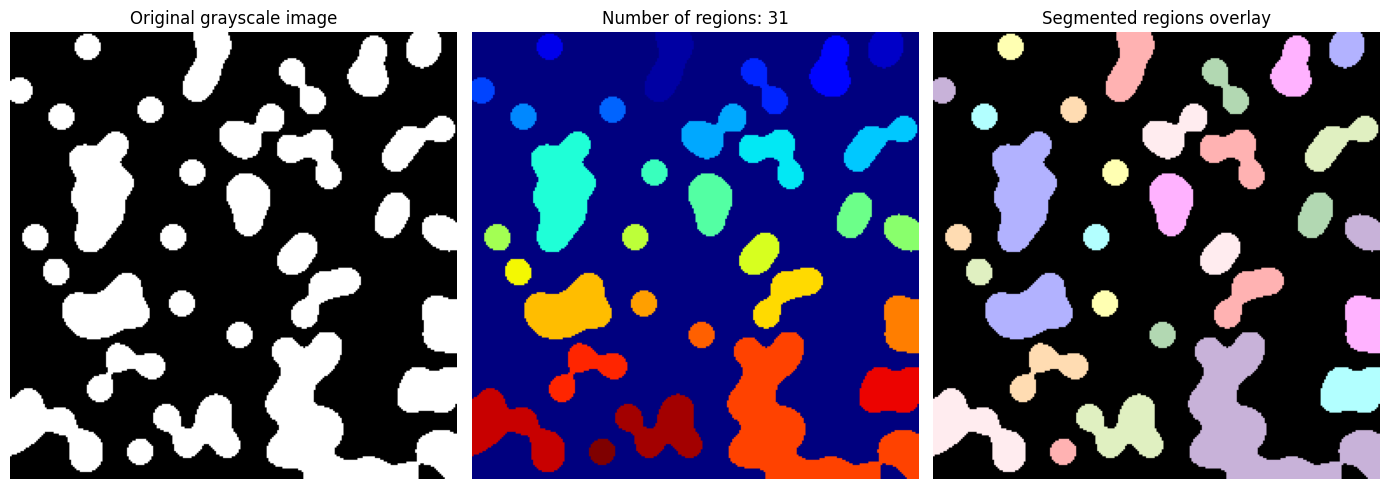

In [20]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

thresh = threshold_otsu(IG) # Automatically finds an optimal global threshold that separates foreground from background in a grayscale image.
bw = IG > thresh # Creates a binary image where pixels above the threshold are True (foreground), and others are False (background).

label_image, nregions = label(bw, return_num = True) # label_image: image where each region has a unique integer label
                                                     # nregions: nr of regions detected
image_label_overlay = label2rgb(label_image, image=IG) # Converts the labeled image to a color image

fig, axes = plt.subplots(1,3,figsize=(14,9))
ax = axes.ravel() # Flattens the axes array to access the subplots more easily
ax[0].imshow(IG, cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

3. Get regional properties in a pandas dataframe

In [6]:
import pandas as pd

# Extracts geometric and shape-related properties from the labeled regions in label_image
props = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent','axis_major_length'])

df_features = pd.DataFrame(props)
df_features.head()

,label,area,eccentricity,extent,axis_major_length
0,1,730.0,0.892310,0.651786,46.973517
1,2,348.0,0.462960,0.828571,22.431451
2,3,177.0,0.000000,0.786667,14.996798
3,4,604.0,0.805509,0.719048,36.915906
4,5,401.0,0.937173,0.464120,41.997253


Represent area of the blobs as a function of the major axis length

<Axes: xlabel='axis_major_length', ylabel='area'>

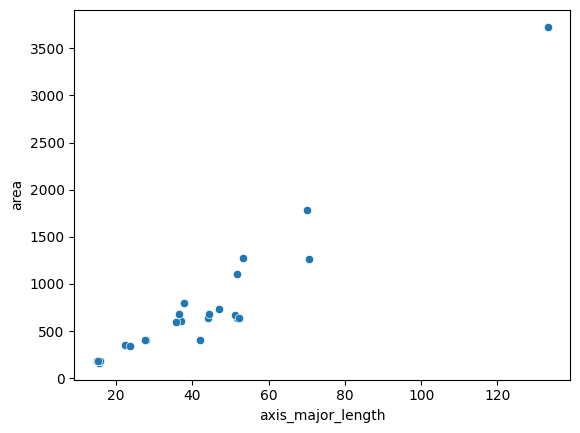

In [7]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

4. Analyze blobs
How many blobs have an area above the average?

In [8]:
df_features.loc[df_features['area']>=df_features['area'].mean()]

,label,area,eccentricity,extent,axis_major_length
0,1,730.0,0.892310,0.651786,46.973517
9,10,638.0,0.934319,0.474702,51.820920
10,11,679.0,0.802746,0.539746,44.338603
11,12,1787.0,0.871032,0.699961,69.991371
13,14,680.0,0.750817,0.755556,36.578878
20,21,668.0,0.921789,0.477143,51.256283
21,22,1274.0,0.796089,0.670526,53.389994
25,26,3729.0,0.812137,0.403571,133.201647
26,27,643.0,0.862571,0.420261,52.321497
27,28,795.0,0.676761,0.899321,37.740593


In [9]:
mean_blobs_area = df_features['area'].mean()
df_large_blobs = df_features.loc[df_features['area']>=mean_blobs_area]
N_large = df_large_blobs.shape[0] # Gets the nr of blobs that satisfy the condition
print('there are {} blobs with an area larger or equal the mean area {}'.format(N_large,mean_blobs_area))


there are 12 blobs with an area larger or equal the mean area 634.2258064516129


In [12]:
mean_blobs_area = df_features['area'].mean()
df_small_blobs = df_features.loc[df_features['area']<=mean_blobs_area]
N_small = df_small_blobs.shape[0]
print('there are {} blobs with an area smaller or equal the mean area {}'.format(N_small,mean_blobs_area))


there are 19 blobs with an area smaller or equal the mean area 634.2258064516129


find the labels of small and large blobs

In [13]:
labels_small = df_small_blobs['label'].values
print('labels of small blobs: {}'.format(labels_small))
labels_large = df_large_blobs['label'].values
print('labels of large blobs: {}'.format(labels_large))


labels of small blobs: [ 2  3  4  5  6  7  8  9 13 15 16 17 18 19 20 23 24 25 31]
labels of large blobs: [ 1 10 11 12 14 21 22 26 27 28 29 30]


Create a binary mask with the large and small blobs

In [14]:
import numpy as np
mask_small_blobs = np.isin(label_image,labels_small)
mask_large_blobs = np.isin(label_image,labels_large)

Represent the large and small blobs

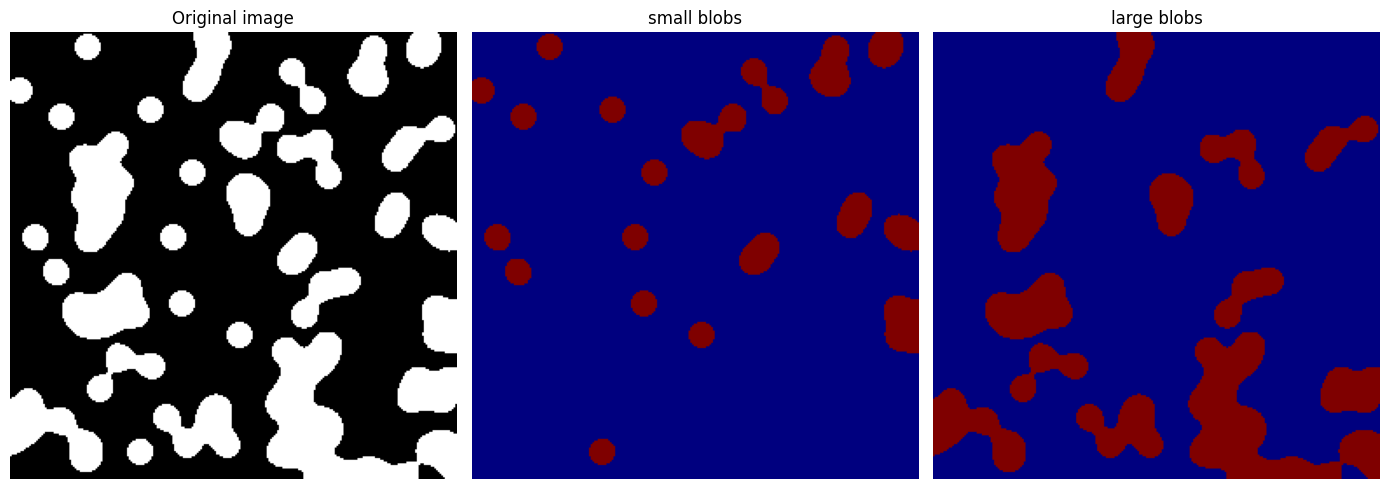

In [15]:
# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(mask_small_blobs,cmap=plt.cm.jet)
ax[1].set_title('small blobs') # set figure title
ax[2].imshow(mask_large_blobs,cmap=plt.cm.jet)
ax[2].set_title('large blobs')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

5. Obtain texture-based regional properties

In [16]:
from skimage.feature.texture import graycomatrix, graycoprops

# This is a 4x4 grayscale image using values from 0 to 3 (4 levels).
image = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
g = graycomatrix(IG, [1], [0], levels=4, normed=False, symmetric=False)
print(image)
print('Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,0,0,0]))
print('Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,1,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,2,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,0,0,0]))


[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 44760
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 953
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 0
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops
from skimage import img_as_ubyte

# Suponiendo que tienes:
# - `IG`: gray image normalized as uint8
# - `label_image`: segmented image with noticeable regions

props = regionprops(label_image, intensity_image=IG)
nregions = len(props)

props_texture = np.zeros((nregions, 5))
for i, p in enumerate(props):
    # For each region, calcuate the texture
    minr, minc, maxr, maxc = p.bbox
    I = IG[minr:maxr, minc:maxc]

    # Convert to uint8 and scale values ​​if necessary
    Iu8 = img_as_ubyte(I)

    # Calculate GLCM
    g = graycomatrix(Iu8, distances=[1], angles=[0], levels=256, normed=True, symmetric=True)

    # Extract features
    props_texture[i, 0] = graycoprops(g, 'contrast')[0, 0]
    props_texture[i, 1] = graycoprops(g, 'dissimilarity')[0, 0]
    props_texture[i, 2] = graycoprops(g, 'homogeneity')[0, 0]
    props_texture[i, 3] = graycoprops(g, 'energy')[0, 0]
    props_texture[i, 4] = graycoprops(g, 'correlation')[0, 0]

# Export an Excel
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("/content/drive/MyDrive/Colab Notebooks/Texture_features.xlsx", index=False)
df

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,4033.958333,15.819444,0.937964,0.706788,0.859728
1,3911.278195,15.338346,0.939851,0.829422,0.764602
2,6192.857143,24.285714,0.904763,0.785758,0.678703
3,5088.913043,19.956522,0.921740,0.740850,0.793509
4,4532.992788,17.776442,0.930290,0.660028,0.860441
5,5057.500000,19.833333,0.922223,0.830105,0.674839
6,6192.857143,24.285714,0.904763,0.785758,0.678703
7,6192.857143,24.285714,0.904763,0.785758,0.678703
8,3725.390625,14.609375,0.942709,0.676704,0.882614
9,2825.019055,11.078506,0.956556,0.677557,0.912998
